# Inicialización de R

In [1]:
R.version.string

[1] "R version 4.0.5 (2021-03-31)"

## Instalación de paquetes

In [2]:
if("tidyverse" %in% rownames(installed.packages()) == FALSE) {install.packages("tidyverse")}
if("rpart" %in% rownames(installed.packages()) == FALSE) {install.packages("rpart")}
if("caret" %in% rownames(installed.packages()) == FALSE) {install.packages("caret")}
if("rpart.plot" %in% rownames(installed.packages()) == FALSE) {install.packages("rpart.plot")}
if("plotmo" %in% rownames(installed.packages()) == FALSE) {install.packages("plotmo")}
if("parsnip" %in% rownames(installed.packages()) == FALSE) {install.packages("parsnip")}
if("e1071" %in% rownames(installed.packages()) == FALSE) {install.packages("e1071")}
if("kernlab" %in% rownames(installed.packages()) == FALSE) {install.packages("kernlab")}

install.packages("remotes")
remotes::install_github("grantmcdermott/parttree")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Skipping install of 'parttree' from a github remote, the SHA1 (9d25d2cf) has not changed since last install.
  Use `force = TRUE` to force installation



# Conjunto de Datos

### Funciones para generar datos.

In [3]:
simulate_bivariate_normal <- function( n, mu, sigma, correlation )
{
    # (mu_x, mu_y) media de la normal bivariada deseada ...
    mu_x <- mu[1]
    mu_y <- mu[2]
    
    # Matriz de covarianza de la normal bivariada deseada ...
    # (      sigma_x^2      , p * sigma_x * sigma_y)
    # (p * sigma_x * sigma_y,     sigma_y^2        )
    sigma_x <- sigma[1]
    sigma_y <- sigma[2]
    p = correlation
    
    set.seed(1) # Semilla para generar especificamente Z1
    Z1 = rnorm(n, 0, 1)
    
    set.seed(2) # Semilla para generar especificamente Z2
    Z2 = rnorm(n, 0, 1)

    X1 = sigma_x * Z1 + mu_x
    X2 = sigma_y * ( p*Z1 + sqrt(1 - p*p)*Z2 ) + mu_y
    
    bivariate = cbind(X1, X2)
    
    return( bivariate )
}

In [4]:
get_sample <- function(n)
{
    set.seed(10) # Semilla para generar especificamente Y
    Y <- rnorm( n, 0.0, 1.0 )
    
    N_0 <- simulate_bivariate_normal(n, c(0.0,0.0), c(1.0,1.0), 0.4)
    N_1 <- simulate_bivariate_normal(n, c(1.0,2.0), c(1.0,1.0), 0.4)
    
    dataset <- replicate(n, c(0.0,0.0,0.0))
    dataset <- t(dataset)
    
    for(i in 1:n)
    {   # Indicadora(Y > 0)
        if( Y[i] > 0.0 ){
            dataset[i,] = c(N_1[i,1], N_1[i,2], 1)
        }else{
            dataset[i,] = c(N_0[i,1], N_0[i,2], 0)
        }
    }
    
    colnames(dataset) = c("X1","X2","Y")
    dataset = data.frame(dataset)
    
    return(dataset)
}

### Generación de datos

In [5]:
# Generamos muestras de tamanios 50, 100, y 500
data_500 <- get_sample(500)
data_100 <- get_sample(100)
data_50 <- get_sample(50)

## División en conjuntos de entrenamiento y prueba


In [6]:
library("dplyr")
# 1. Dividimos en conjuntos disjuntos de 75% y 25% del total
sample_proportion <- 0.75
# 2. Creamos un ID por fila para hacer la division estratificada del conjunto
data_500 <- data_500 %>% mutate(id = row_number())
data_100 <- data_100 %>% mutate(id = row_number())
data_50 <- data_50 %>% mutate(id = row_number())
# 3. Dividimos en conjuntos de entrenamiento y prueba
set.seed(500)
train_500 <- data_500 %>% sample_frac(sample_proportion)
set.seed(100)
train_100 <- data_100 %>% sample_frac(sample_proportion)
set.seed(50)
train_50 <- data_50 %>% sample_frac(sample_proportion)

test_500  <- anti_join(data_500, train_500, by = 'id')
test_100  <- anti_join(data_100, train_100, by = 'id')
test_50  <- anti_join(data_50, train_50, by = 'id')
# 4. Eliminamos la columna auxiliar
train_500 <- select(train_500, -id)
train_100 <- select(train_100, -id)
train_50 <- select(train_50, -id)

test_500 <- select(test_500, -id)
test_100 <- select(test_100, -id)
test_50 <- select(test_50, -id)

data_500 <- select(data_500, -id)
data_100 <- select(data_100, -id)
data_50 <- select(data_50, -id)
# 6. Tranformamos a factor, NECESARIO PARA USAR rpart
train_500$Y <- as.factor(train_500$Y)
train_100$Y <- as.factor(train_100$Y)
train_50$Y <- as.factor(train_50$Y)

test_500$Y <- as.factor(test_500$Y)
test_100$Y <- as.factor(test_100$Y)
test_50$Y <- as.factor(test_50$Y)

data_500$Y <- as.factor(data_500$Y)
data_100$Y <- as.factor(data_100$Y)
data_50$Y <- as.factor(data_50$Y)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [7]:
# Guardamos la cantidad de registros en cada subconjunto
N_train_500 <- nrow(train_500)
N_train_100 <- nrow(train_100)
N_train_50 <- nrow(train_50)

N_test_500 <- nrow(test_500)
N_test_100 <- nrow(test_100)
N_test_50 <- nrow(test_50)

In [8]:
# Observamos la cantidad de registros de cada clase en cada conjunto

print("Data size")
table(data_500$Y)
table(data_100$Y)
table(data_50$Y)

print("Train size")
table(train_500$Y)
table(train_100$Y)
table(train_50$Y)

print("Test size")
table(test_500$Y)
table(test_100$Y)
table(test_50$Y)

[1] "Data size"



  0   1 
253 247 


 0  1 
56 44 


 0  1 
33 17 

[1] "Train size"



  0   1 
190 185 


 0  1 
45 30 


 0  1 
25 13 

[1] "Test size"



 0  1 
63 62 


 0  1 
11 14 


0 1 
8 4 

In [9]:
# Verificamos que tengan la misma proporcion de registros por epecie
print("Data size")
table(data_500$Y) / 500.0
table(data_100$Y) / 100.0
table(data_50$Y) / 50.0

print("Train size")
table(train_500$Y) / N_train_500
table(train_100$Y) / N_train_100
table(train_50$Y) / N_train_50

print("Test size")
table(test_500$Y) / N_test_500
table(test_100$Y) / N_test_100
table(test_50$Y) / N_test_50

[1] "Data size"



    0     1 
0.506 0.494 


   0    1 
0.56 0.44 


   0    1 
0.66 0.34 

[1] "Train size"



        0         1 
0.5066667 0.4933333 


  0   1 
0.6 0.4 


        0         1 
0.6578947 0.3421053 

[1] "Test size"



    0     1 
0.504 0.496 


   0    1 
0.44 0.56 


        0         1 
0.6666667 0.3333333 

## Análisis exploratorio de datos

### Medias muestrales

In [10]:
# Division por clases
class_0_500 <- train_500 %>% filter(Y == "0") %>% select(X1, X2)
class_1_500 <- train_500 %>% filter(Y == "1") %>% select(X1, X2)

class_0_100 <- train_100 %>% filter(Y == "0") %>% select(X1, X2)
class_1_100 <- train_100 %>% filter(Y == "1") %>% select(X1, X2)

class_0_50 <- train_50 %>% filter(Y == "0") %>% select(X1, X2)
class_1_50 <- train_50 %>% filter(Y == "1") %>% select(X1, X2)
# Calculo de medias muestrales
mean_0_500 <- colMeans(class_0_500)
mean_1_500 <- colMeans(class_1_500)

mean_0_100 <- colMeans(class_0_100)
mean_1_100 <- colMeans(class_1_100)

mean_0_50 <- colMeans(class_0_50)
mean_1_50 <- colMeans(class_1_50)

### 500

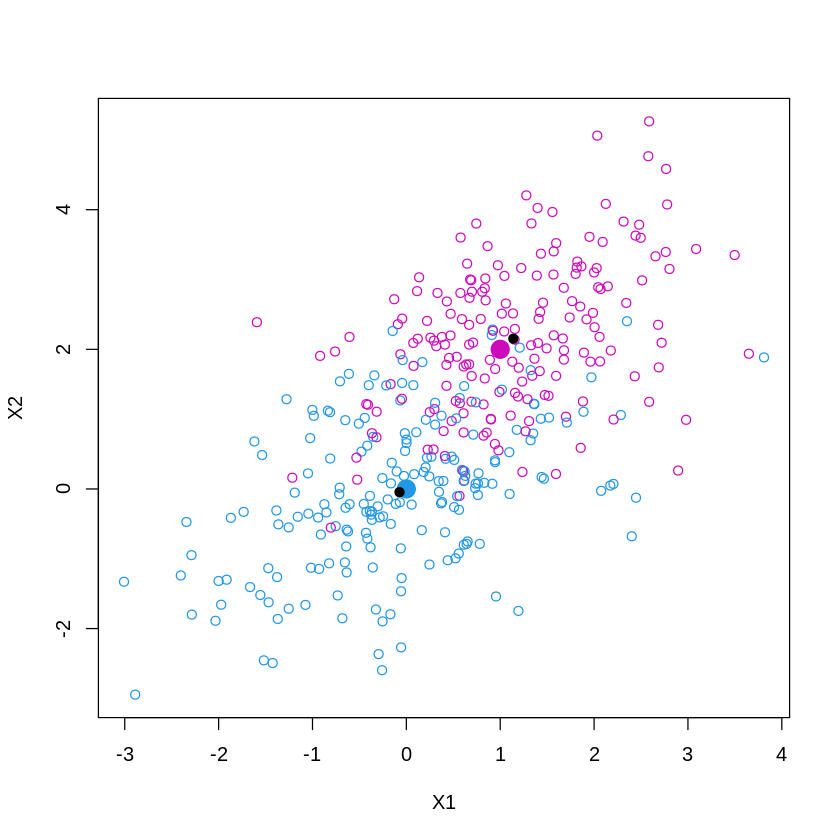

In [11]:
# Mostramos los datos en el plano del conjunto de entrenamiento
plot(
    select(train_500, -Y), 
    col = (as.integer(as.character(train_500$Y)) * 50 + 100)
)
# Mostramos las medias teoricas de las distribuciones
points(
    c(1,0), c(2,0), col = c(150, 100), 
    type="p", pch=19, cex=2
)
# Medias muestrales en puntos negros
points(
    c(mean_0_500[1],mean_1_500[1]), 
    c(mean_0_500[2],mean_1_500[2]), 
    col = "black", type="p", 
    pch=19, cex=1
)

### 100

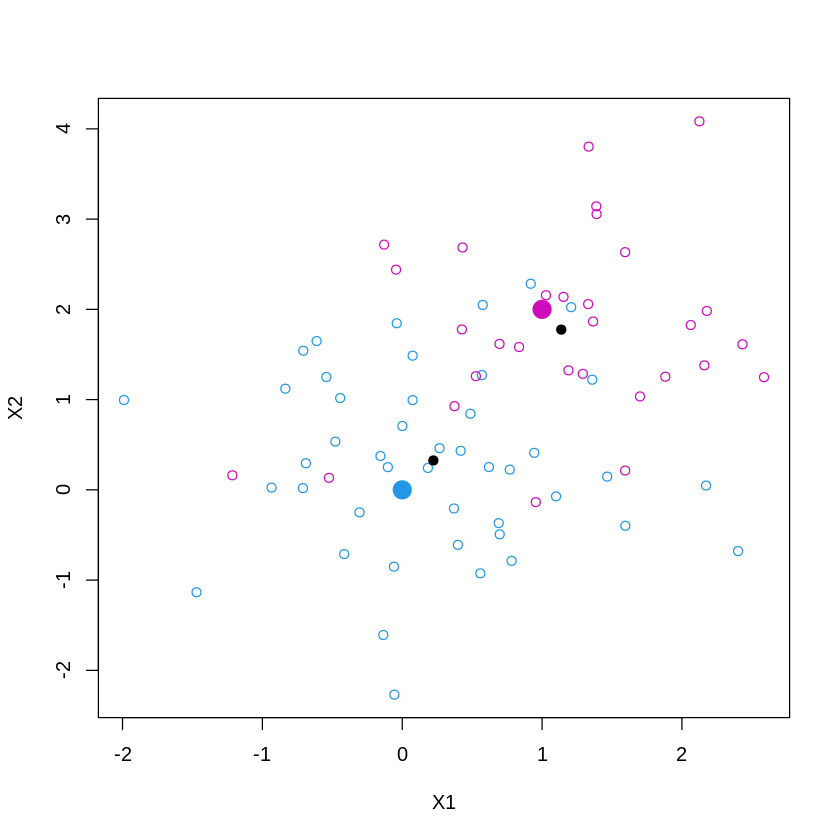

In [12]:
# Mostramos los datos en el plano del conjunto de entrenamiento
plot(
    select(train_100, -Y), 
    col = (as.integer(as.character(train_100$Y)) * 50 + 100)
)
# Mostramos las medias teoricas de las distribuciones
points(
    c(1,0), c(2,0), col = c(150, 100), 
    type="p", pch=19, cex=2
)
# Medias muestrales en puntos negros
points(
    c(mean_0_100[1],mean_1_100[1]), 
    c(mean_0_100[2],mean_1_100[2]), 
    col = "black", type="p", 
    pch=19, cex=1
)

### 50

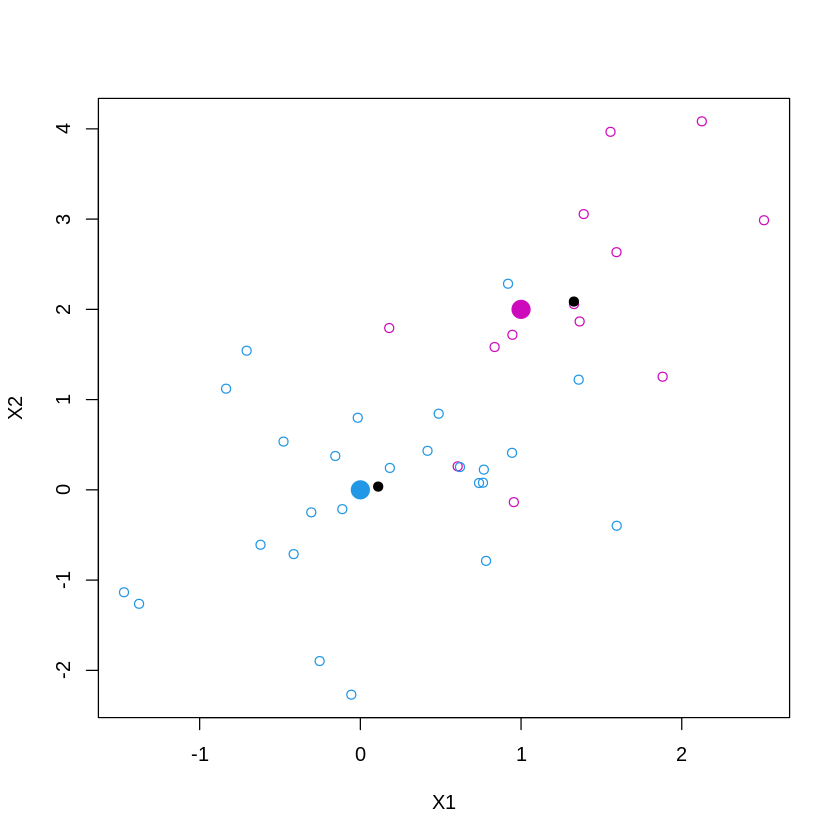

In [13]:
# Mostramos los datos en el plano del conjunto de entrenamiento
plot(
    select(train_50, -Y), 
    col = (as.integer(as.character(train_50$Y)) * 50 + 100)
)
# Mostramos las medias teoricas de las distribuciones
points(
    c(1,0), c(2,0), col = c(150, 100), 
    type="p", pch=19, cex=2
)
# Medias muestrales en puntos negros
points(
    c(mean_0_50[1],mean_1_50[1]), 
    c(mean_0_50[2],mean_1_50[2]), 
    col = "black", type="p", 
    pch=19, cex=1
)

# Clasificador de Bayes

In [14]:
bayes <- function(x){
    # Calculamos b y b_0 como en el ejercicio
    b <- c(1, 8)
    b_0 <- -8.5
    #Indicadora ...
    if( t(b) %*% x + b_0 > 0 )
        return(1)
    return(0)
}

In [15]:
bayes_model <- function(test)
{
    print("Bayes")
    bayes_predict <- apply(select(test, X1, X2), MARGIN=1, bayes)     
    
    matrizConfusion <- table(test$Y, bayes_predict)
    
    hits  = matrizConfusion[1,1] + matrizConfusion[2,2]
    total = sum(matrizConfusion)
    
    precision <- hits / total
    
    print("Precision del modelo:")
    print(precision)
}

# Arboles

## Funciones Auxiliares

In [16]:
library("rpart.plot") # Para mostrar arboles de descicion de rpart
library("plotmo") # Para mostrar particion del planoTree
library("rpart") # Para arboles de descicion (rpart function)
library("caret") # Para validacion cruzada

Loading required package: rpart

Loading required package: Formula

Loading required package: plotrix

Loading required package: TeachingDemos

Loading required package: lattice

Loading required package: ggplot2

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [17]:
precisionDecisionTree <- function(train, folds, alpha )
{
    # Dado un alpha, calculamos la presicion para T(alpha)
    cvDecisionTree <- lapply(folds, function(x){
        
        # x es conjunto de pruba y folds menos x es el conjunto de entrenamiento         
        training_fold <- train[-x, ] # folds menos elementos de x
        test_fold     <- train[ x, ] # elementos de x

        training_fold$Y <- as.factor(training_fold$Y)
        test_fold$Y <- as.factor(test_fold$Y)
             
        set.seed(1234)
        # Creamos un arbol T(alpha)
        clasificador <- rpart(Y ~ ., data = training_fold, cp = alpha)
        
        # cm es la matriz de confunsion, donde filas representan clase verdadera
        # y la columna la clase en la que se clasifico usando el arbol
        # Celda(i,j) contiene la cantidad de clase i, que fue clasificado como j
        y_pred <- predict(clasificador, newdata = test_fold, type = 'class')
        cm     <- table(test_fold$Y, y_pred)
        
        # Calculamos % de aciertos, es decir, la precicion del modelo. La matriz
        # cm es de 2x2 pues exusten 2 clases.
        hits  = cm[1,1] + cm[2,2]
        total = sum(cm)
        
        precision <- hits / total
        
        return(precision)
    })
    
    # Retornamos el promedio de los k modelos entrenados
    return (mean(as.numeric(cvDecisionTree)))
}

In [18]:
get_tree <- function(train, Alphas, k)
{
    max_precision = 0.0 # La presision esta acotada por 0.0
    alpha_optimal = 0.0 # Alpha = 0.0 genera el arbol maximo (Arbol saturado)
    
    # Particionamos el conjunto de entrenamiento en 10 para validacion cruzada
    set.seed(1234)
    folds <- createFolds(train$Y, k = k)# Ya estan balanceados
    
    # Repetimos validacion cruzada para todos los arboles usados como modelos.
    # Nos quedamos con arbol con mayor precision. Basta guardar alpha*.
    print("(Alpha, presicion)")
    for(alpha in Alphas)
    {
        precision <- precisionDecisionTree(train, folds, alpha) 
        print(c(alpha,precision))
        # Alphas se supone ordenados ascendentemente y 
        # buscamos el mayor alpha con mayor precision (Por esto <= en vez de <)
        if( max_precision <= precision )
        {
            max_precision = precision
            alpha_optimal = alpha
        }
    }
    
    return (alpha_optimal)
}

In [19]:
tree_model <- function(train, test, Alphas, k)
{
    print("Arboles")
    # T(alpha) es creciente y luego decreciente, 
    # entonces buscamos alpha que maximiza
    alpha = get_tree(train, Alphas, k)
    print("Alpha optimo")
    print(alpha)
    # Clasificador con alpha optimo encontrado
    clasificador <- rpart(Y ~ ., data = train, cp = alpha)
    
    pred_valid_DT <- predict(clasificador, newdata = test, type = 'class')
    matrizConfusion <- table(test$Y, pred_valid_DT)
    
    hits  = matrizConfusion[1,1] + matrizConfusion[2,2]
    total = sum(matrizConfusion)
    
    precision <- hits / total
    
    print("Precision del modelo:")
    print(precision)

    return (alpha)
}

## Comparacion

Para este ejercicio se particionó la muestra de tamaño $n$ en dos partes para validación cruzada, tomando un 75\% como el conjunto de entrenamiento/prueba y la parte restante como el conjunto de validación. 
    
El conjutno de prueba se volvió a particionar en $k = 5$ y $k = 10$ para $n = 50$ y $n = 100, 500$ respectivamente. Para cada muestra de tamaño $n$, buscamos un $\alpha \geq 0$ que nos induzca un arbol que otorgue un poder de predicción bueno y además no tenga una gran cantidad de nodos hoja. 
    
Para $\alpha = 0$, el arbol correspondiente es el arbol saturado, el cual se pudo haber sobreajustado al conjuto de entrenamiento. Conforme $\alpha$ crece, el poder de predicción aumenta (Pues el sobreajuste pudo agregar más nodos de lo necesario) en el conjunto de prueba y la cantidad de nodos hoja disminuye, pero llega un punto en el que el poder de predicción disminuye (Quitamos nodos necesarios para lograr buena precision), pues en algún momento llegaremos a un arbol de solo un nodo (la raiz) debido a que entre más grande $\alpha$, más se penaliza árboles grandes. Para obtener el mejor arbol basta guardar el parámetro $\alpha$ cuyo arbol logra la máxima precisión promedio, posteriormente calculamos su poder predictivo con el conjunto de validación.
    
A continuación, para cada muestra con $n=50, 100, 500$ se presentan los resultados obtenidos en el siguiente orden:

* Precisión promedio obtenida con árboles generados con diferentes parámetros $\alpha$. 
* Presición obtenida en el mismo conjunto de validación con el Clasificador de Bayes. 
* Visualizacion del arbol de desición y la particion del plano por el árbol obtenido junto con la recta generada por el clasificador de Bayesiano óptimo.

In [20]:
library("tidyverse")
library("parttree")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.1     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()



In [21]:
# Alphas ordenados ascendentemente
Alphas = c(0.0, 0.2, 0.5, 0.7, 1.0)
# Tamanio de la particion del conjunto de entrenamiento para cada n
k = c(5, 10, 10)

###50

#### Elección de modelo

En este caso, el modelo basado en un árbol logra una precisión de $0.666$ sobre el conjunto de prueba al igual que el clasificador Bayesiano óptimo, a pesar de que las fronteras de desición son muy diferentes (Casi ortogonales). 

Notamos que el árbol obtenido solo tiene una división.

In [22]:
alpha_optim_50 <- tree_model(train_50, test_50, Alphas, k[1]) # k = 5
bayes_model(test_50)

[1] "Arboles"
[1] "(Alpha, presicion)"
[1] 0.0000000 0.7642857
[1] 0.2000000 0.7642857
[1] 0.5000000 0.7642857
[1] 0.7000000 0.7142857
[1] 1.0000000 0.6607143
[1] "Alpha optimo"
[1] 0.5
[1] "Precision del modelo:"
[1] 0.6666667
[1] "Bayes"
[1] "Precision del modelo:"
[1] 0.6666667


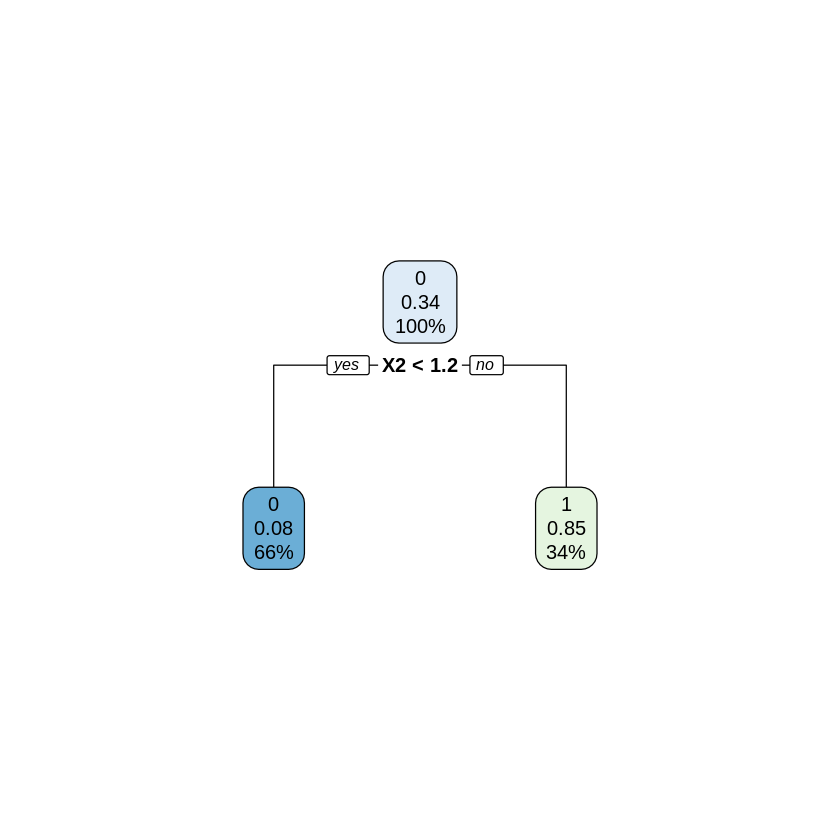

In [23]:
## Fit a decision tree using the same variables as the above plot
tree = rpart(Y ~ ., data = train_50, cp = alpha_optim_50)
rpart.plot(tree)

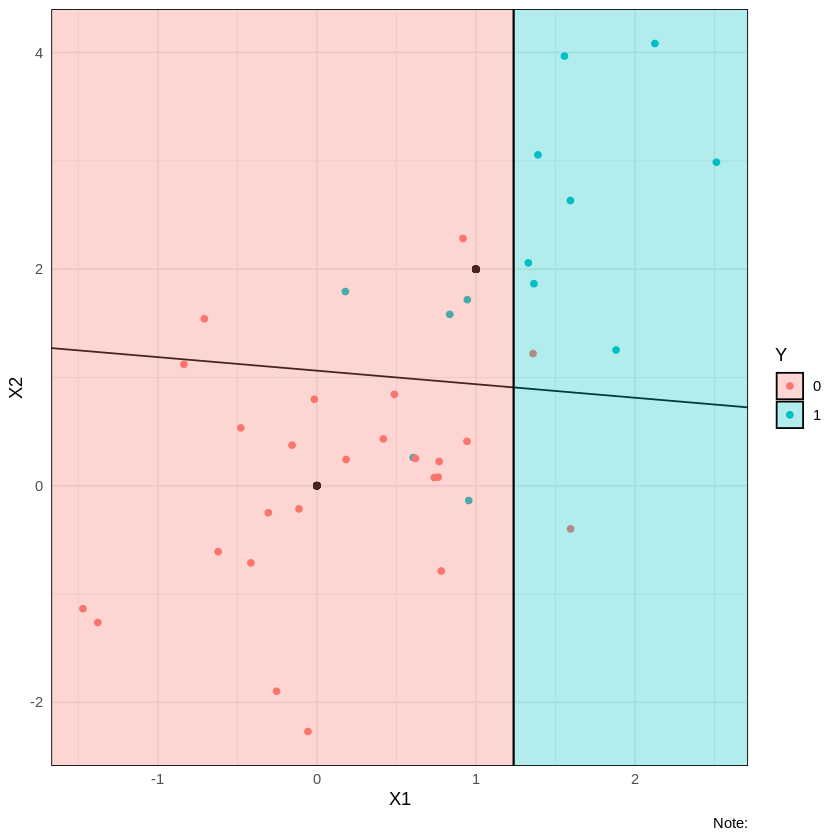

In [24]:
## First construct a scatterplot of the raw data
p = ggplot(data = train_50, aes(x = X1, y = X2)) +
    geom_point(aes(col = Y)) +
    geom_point(aes(x=1.0, y=2.0), colour="black")+
    geom_point(aes(x=0.0, y=0.0), colour="black")+
    geom_abline(intercept=1.0625, slope=-0.125) +
    theme_minimal()

# Visualise the tree partitions by adding it via geom_parttree()
p +  
  geom_parttree(data = tree, aes(fill=Y), alpha = 0.3) +
  labs(caption = "Note:")

#### Visualizaciósobre datos nuevos

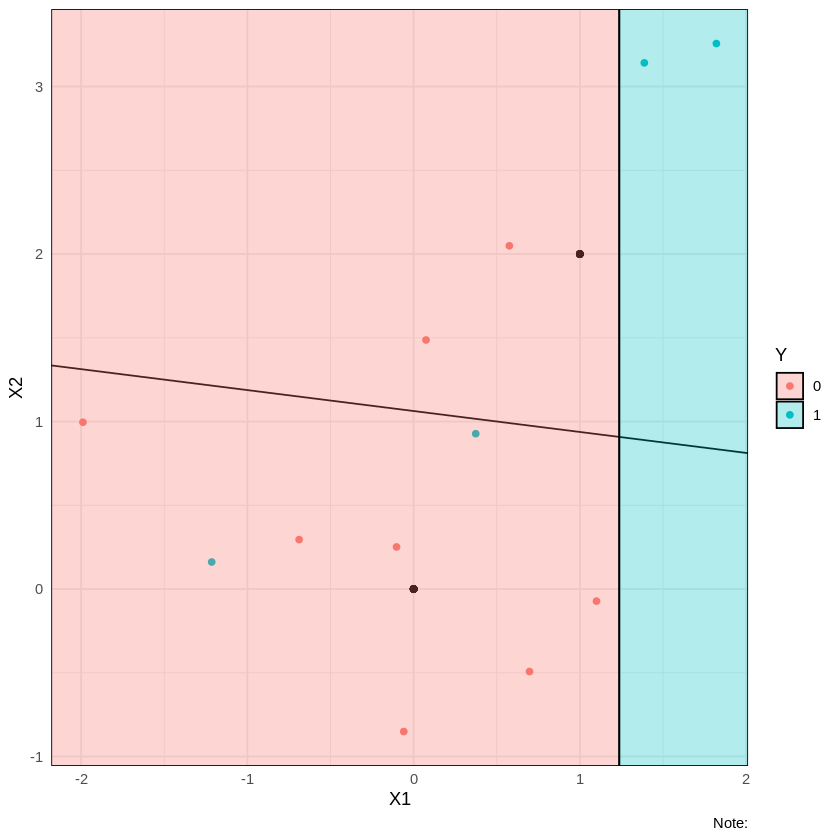

In [25]:
## First construct a scatterplot of the raw data
p = ggplot(data = test_50, aes(x = X1, y = X2)) +
    geom_point(aes(col = Y)) +
    geom_point(aes(x=1.0, y=2.0), colour="black")+
    geom_point(aes(x=0.0, y=0.0), colour="black")+
    geom_abline(intercept=1.0625, slope=-0.125) +
    theme_minimal()

# Visualise the tree partitions by adding it via geom_parttree()
p +  
  geom_parttree(data = tree, aes(fill=Y), alpha = 0.3) +
  labs(caption = "Note:")

### 100

#### Elección de modelo

En este caso, el modelo basado en un árbol logra una precisión de $0.76$ sobre el conjunto de prueba, mientras que el clasificador Bayesiano óptimo obtuvo una precisión de $0.8$.

Nuevamente, el arbol solo tiene una división.

In [26]:
alpha_optim_100 <- tree_model(train_100, test_100, Alphas, k[2]) # k = 10
bayes_model(test_100)

[1] "Arboles"
[1] "(Alpha, presicion)"
[1] 0.0000000 0.7053571
[1] 0.200 0.775
[1] 0.5000000 0.6107143
[1] 0.7000000 0.5982143
[1] 1.0000000 0.5982143
[1] "Alpha optimo"
[1] 0.2
[1] "Precision del modelo:"
[1] 0.76
[1] "Bayes"
[1] "Precision del modelo:"
[1] 0.8


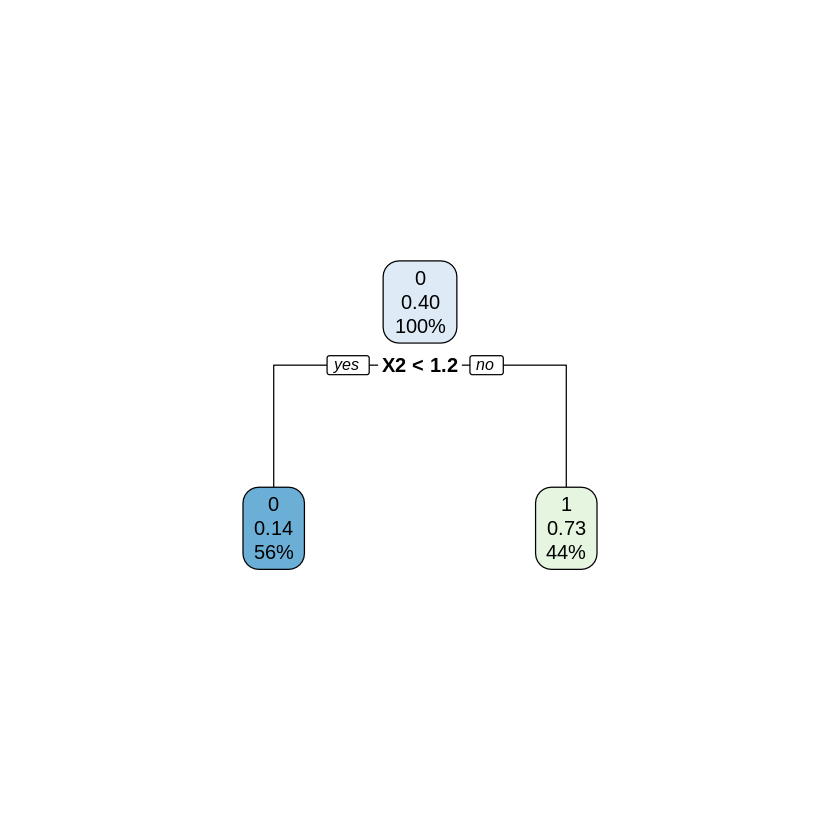

In [27]:
## Fit a decision tree using the same variables as the above plot
tree = rpart(Y ~ ., data = train_100, cp = alpha_optim_100)
rpart.plot(tree)

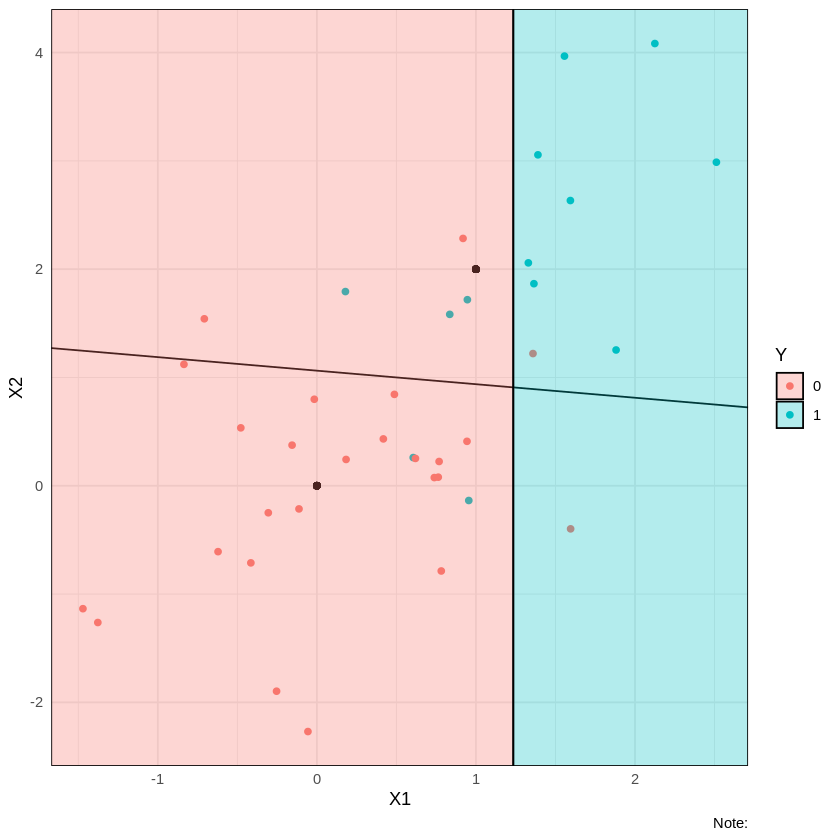

In [28]:
## First construct a scatterplot of the raw data
p = ggplot(data = train_50, aes(x = X1, y = X2)) +
    geom_point(aes(col = Y)) +
    geom_point(aes(x=1.0, y=2.0), colour="black")+
    geom_point(aes(x=0.0, y=0.0), colour="black")+
    geom_abline(intercept=1.0625, slope=-0.125) +
    theme_minimal()

# Visualise the tree partitions by adding it via geom_parttree()
p +  
  geom_parttree(data = tree, aes(fill=Y), alpha = 0.3) +
  labs(caption = "Note:")

#### Visualizaciósobre datos nuevos

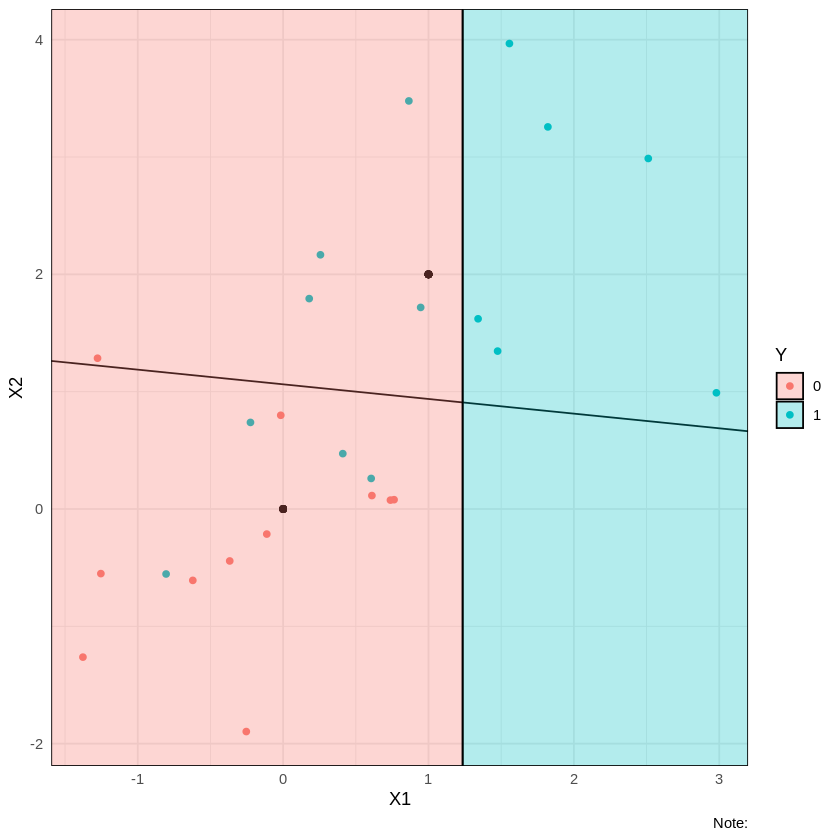

In [29]:
## First construct a scatterplot of the raw data
p = ggplot(data = test_100, aes(x = X1, y = X2)) +
    geom_point(aes(col = Y)) +
    geom_point(aes(x=1.0, y=2.0), colour="black")+
    geom_point(aes(x=0.0, y=0.0), colour="black")+
    geom_abline(intercept=1.0625, slope=-0.125) +
    theme_minimal()

# Visualise the tree partitions by adding it via geom_parttree()
p +  
  geom_parttree(data = tree, aes(fill=Y), alpha = 0.3) +
  labs(caption = "Note:")

###500

#### Elección de modelo

En este caso, el modelo basado en un árbol logra una precisión de $0.808$ sobre el conjunto de prueba. Por otro lado, el clasificador Bayesiano óptimo obtuvo una precisión de $.824$.

En este caso, el arbol ya tiene más divisiones anque la frontera de desición siguen siendo bastante distinta a la inducida por el clasificador Basyesiano óptimo.

In [30]:
alpha_optim_500 <- tree_model(train_500, test_500, Alphas, k[3])
bayes_model(test_500)

[1] "Arboles"
[1] "(Alpha, presicion)"
[1] 0.0000000 0.8375533
[1] 0.2000000 0.8106686
[1] 0.5000000 0.8106686
[1] 0.7000000 0.5067568
[1] 1.0000000 0.5067568
[1] "Alpha optimo"
[1] 0
[1] "Precision del modelo:"
[1] 0.808
[1] "Bayes"
[1] "Precision del modelo:"
[1] 0.824


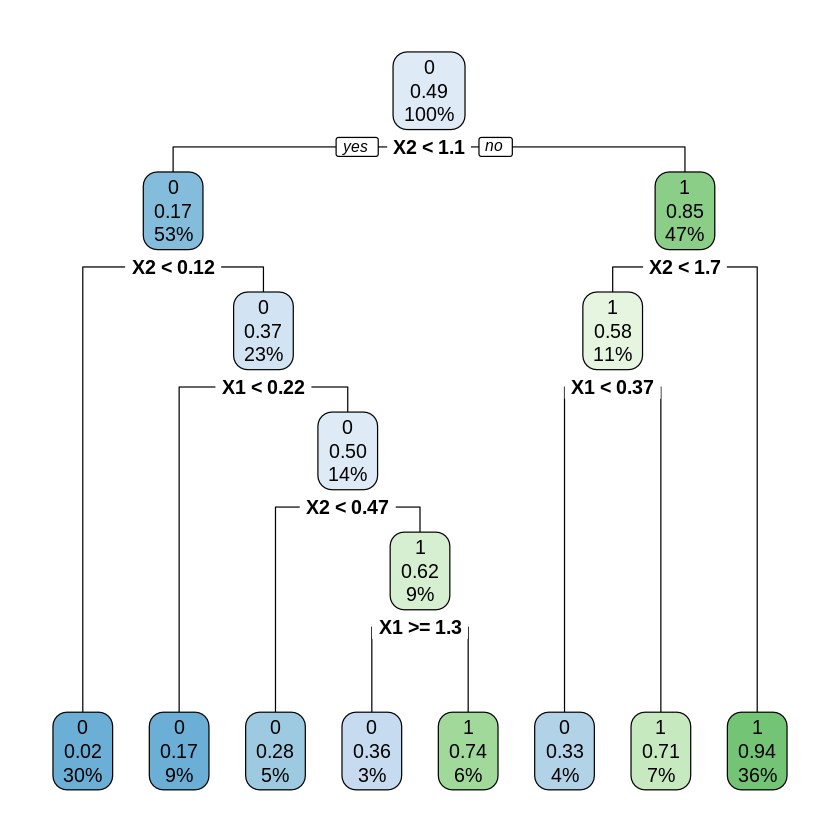

In [31]:
## Fit a decision tree using the same variables as the above plot
tree = rpart(Y ~ ., data = train_500, cp = alpha_optim_500)
rpart.plot(tree)

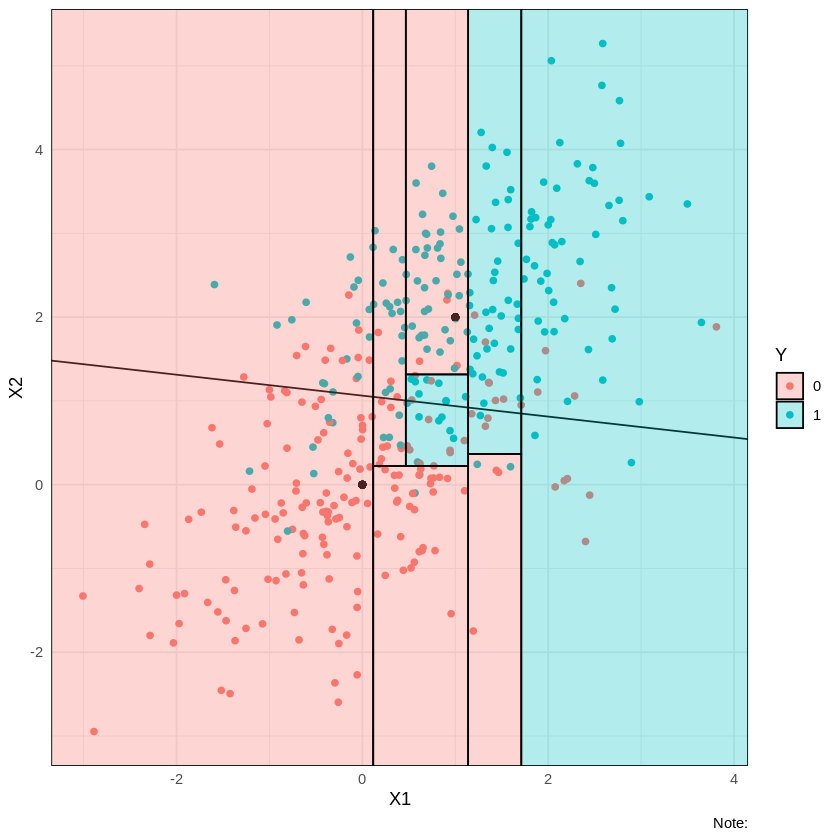

In [32]:
## First construct a scatterplot of the raw data
p = ggplot(data = train_500, aes(x = X1, y = X2)) +
    geom_point(aes(col = Y)) +
    geom_point(aes(x=1.0, y=2.0), colour="black")+
    geom_point(aes(x=0.0, y=0.0), colour="black")+
    geom_abline(intercept=1.0625, slope=-0.125) +
    theme_minimal()

# Visualise the tree partitions by adding it via geom_parttree()
p +  
  geom_parttree(data = tree, aes(fill=Y), alpha = 0.3) +
  labs(caption = "Note:")

#### Visualización en datos nuevos

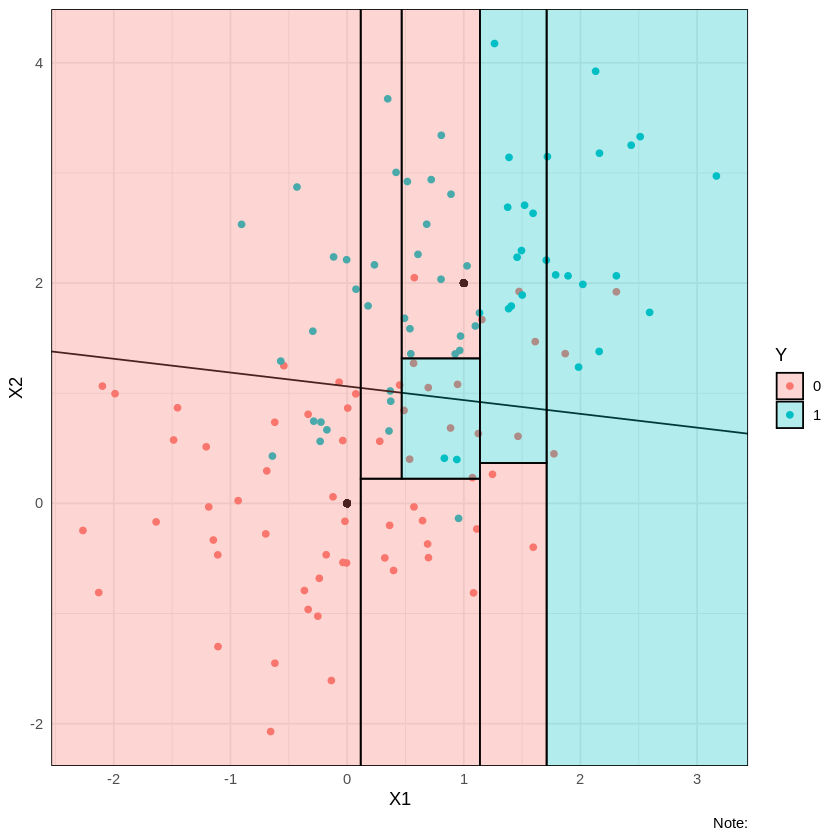

In [33]:
library("tidyverse")
library("parttree")
## First construct a scatterplot of the raw penguin data
p = ggplot(data = test_500, aes(x = X1, y = X2)) +
    geom_point(aes(col = Y)) +
    geom_point(aes(x=1.0, y=2.0), colour="black")+
    geom_point(aes(x=0.0, y=0.0), colour="black")+
    geom_abline(intercept=1.0625, slope=-0.125) +
    theme_minimal()

# Visualise the tree partitions by adding it via geom_parttree()
p +  
  geom_parttree(data = tree, aes(fill=Y), alpha = 0.3) +
  labs(caption = "Note:")

### Observaciones

Para $n=50, 100, 500$ se tienen $\alpha* = 0.5, 0.2, 0.0$ respectivamente, por lo que podemos notar que conforme el tamaño de la muestra aumenta, el valor óptimo de $\alpha$ disminuye. Un $\alpha$ pequeño se traduce en una mayor cantidad de nodos lo cual es razonable pues conforme aumenta el tamaño de la muestra es más dificil separar los datos.

# SVM

## Funciones Auxiliares

In [34]:
library(e1071)

In [35]:
precisionKernelSVM <-function(train, folds, C, gamma)
{   # gamma = 1/sigma^2, C costo de no cumplir condiciones de lagrange.
    cvKernelSVM <- lapply(folds, function(x){
        training_fold <- train[-x,]
        test_fold     <- train[x,]
        
        set.seed(1234)
        clasificador <- svm(
            Y ~ ., data = training_fold, 
            type = 'C-classification', 
            kernel = 'radial',
            gamma = gamma,
            cost  = C
        )
        y_pred <- predict(clasificador, newdata = test_fold)
        cm <- table(test_fold$Y, y_pred)
        precision <- (cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] +cm[1,2] + cm[2,1])
        return(precision)
    })
    
    # Retornamos el promedio de los k modelos entrenados
    return (mean(as.numeric(cvKernelSVM)))
}

get_SVM <- function(training_set, C, Gammas, k )
{
    max_precision = 0.0 # La presision esta acotada por 0.0
    gamma_optimal = 100.0 
    costo_optimal = 0.0
    
    # Particionamos el conjunto de entrenamiento en subconjuntos para validacion cruzada
    set.seed(1234)
    folds <- createFolds(training_set$Y, k = k) # Ya estan balanceados
    print("(c, gamma, precision):")
    for(c in C)
    {
        for(gamma in Gammas)
        {
            precision <- precisionKernelSVM(training_set, folds, c, gamma)
            
            print(c(round(c, 2), round(gamma, 2), round(precision, 2)))
            
            if( max_precision < precision )
            {
                max_precision = precision
                gamma_optimal = gamma
                costo_optimal = c
            }
        }
    }
    
    return (c(costo_optimal, gamma_optimal))
}

svm_model <- function(training_set, test_set, k)
{
    # Uso busqueda greedy como en izenman
    C = c( 10, 100, 1000 )
    Gammas = c(0.0001, 0.001, 0.01, 0.1, 1.0, 10)

    parameters = get_SVM(training_set, C, Gammas, k)

    print("(c*, gamma*):")
    print(parameters)
    
    gamma = parameters[2]
    C = parameters[1]
    
    set.seed(1234)
    clasificador <- svm(
        Y ~ . ,data = training_set, 
        type = 'C-classification', 
        kernel = 'radial',
        gamma = gamma,
        cost  = C
    )
    
    y_pred <- predict(clasificador, newdata = test_set)
    cm <- table(test_set$Y, y_pred)
    precision <- (cm[1,1] + cm[2,2]) / (cm[1,1] + cm[2,2] +cm[1,2] + cm[2,1])
    
    print(c("Precision del modelo:",precision))

    return (c(C, gamma))
}

## Comparación

Para este ejercicio se particionó la muestra de tamaño $n$ en dos partes iguales para validación cruzada, tomando la primera mitad como el conjunto de entrenamiento/prueba y la otra mitad como el conjunto de validación. 
    
El conjutno de prueba se volvió a particionar en $k = 5$ y $k = 10$ para $n = 50$ y $n = 100, 500$ respectivamente. Para cada muestra de tamaño $n$, buscamos parámetros $(C, \gamma)$, donde $C$ es el parámetro de costo por violar las restricciones y el parámetro de kernel $\gamma = \frac{1}{\sigma^2}$. 
    
Según Izeman (pag 385) es habitual comenzar la búsqueda probando varios valores diferentes de $C$, como $10, 100, 1,000$ etc. Se puede seleccionar una cuadrícula inicial de valores de $\gamma$ probando un conjunto de valores posibles, por ejemplo, $0.00001, 0.0001, 0.001, 0.01, 0.1 y 1.0$. 
    
Tomaremos los valores $C = 10, 100, 1, 000$ y $\gamma = 0.0001, 0.001, 0.01, 0.1, 1.0$ y mediante validación cruzada nos quedaremos con los parámetros $(C^{*}, \gamma^{*})$ que nos generen el mejor modelo. 

A continuación, para cada muestra con $n=50, 100, 500$ se presentan los resultados obtenidos en el siguiente orden:

* Precición promedio de diferentes SVM con diferentes parámetros $(C, \gamma)$. 
* Luego se presenta la presición obtenida en el mismo conjunto de validación con el Clasificador de Bayes (Dado que se usan los mismo conjuntos de validación se obtienen los mismos resultados que en el inciso anterior). 
* Visualizacion de la particion del plano por la SVM obtenida junto con la recta generada por el clasificador de Bayesiano óptimo.

###50

#### Elección de modelo

En este caso, el modelo basado en SVM logra una precisión de $0.75$ sobre el conjunto de prueba, mientras que el clasificador Bayesiano óptimo obtiene $0.666$. Notamos que el modelo basado en SVM obtuvo un mejor resultado en este caso.

Podemos notar que las fronteras de desición de ambos clasificadores se parecen un poco.

In [36]:
params <- svm_model(train_50, test_50, 10)
C_optim_50 <- params[1]
gamma_optim_50 <- params[2]

bayes_model(test_50)

[1] "(c, gamma, precision):"
[1] 10.00  0.00  0.66
[1] 10.00  0.00  0.66
[1] 10.00  0.01  0.83
[1] 10.00  0.10  0.87
[1] 10.0  1.0  0.8
[1] 10.00 10.00  0.73
[1] 100.00   0.00   0.66
[1] 100.00   0.00   0.83
[1] 100.00   0.01   0.87
[1] 100.00   0.10   0.81
[1] 100.00   1.00   0.73
[1] 100.00  10.00   0.66
[1] 1000.00    0.00    0.83
[1] 1000.00    0.00    0.87
[1] 1000.00    0.01    0.87
[1] 1000.00    0.10    0.78
[1] 1000.00    1.00    0.73
[1] 1000.00   10.00    0.62
[1] "(c*, gamma*):"
[1] 10.0  0.1
[1] "Precision del modelo:" "0.75"                 
[1] "Bayes"
[1] "Precision del modelo:"
[1] 0.6666667


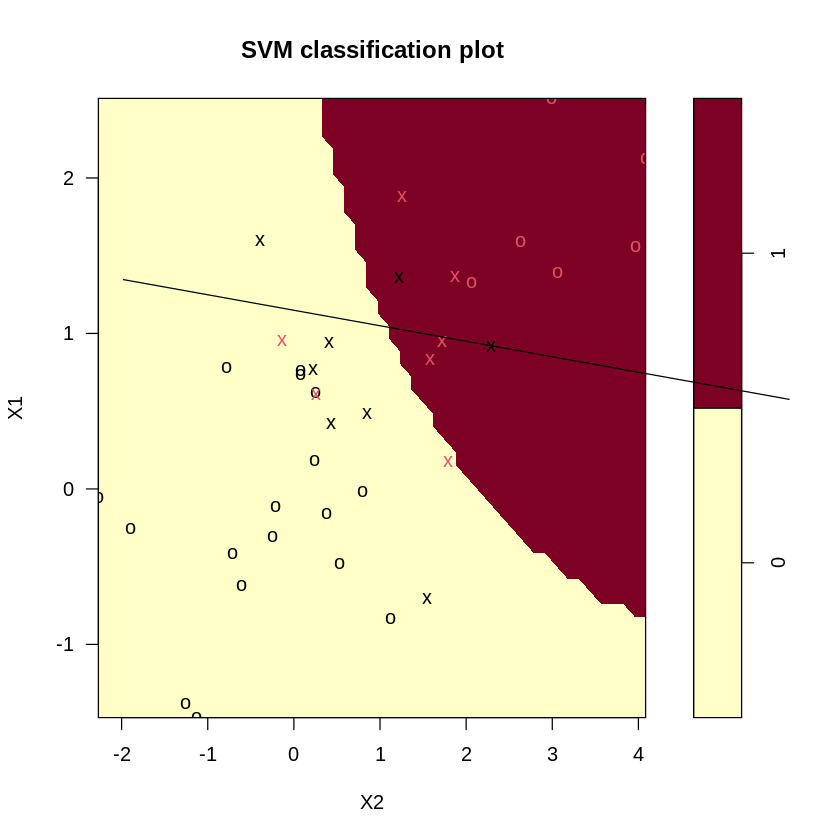

In [37]:
clasificador <- svm(
    Y ~ . ,data = train_50, 
    type = 'C-classification', 
    kernel = 'radial',
    gamma = gamma_optim_50,
    cost  = C_optim_50
)
plot(clasificador, train_50) # Imprimimos svm
abline(a=1.0625, b=-0.125)

#### Visualizaciósobre datos nuvos

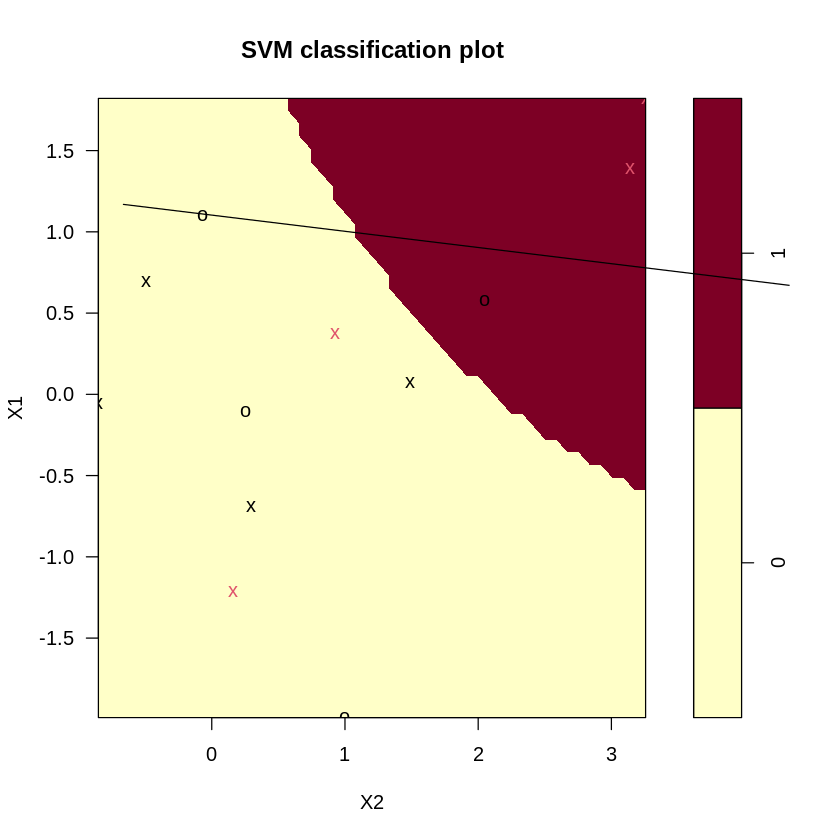

In [38]:
plot(clasificador, test_50) # Imprimimos svm
abline(a=1.0625, b=-0.125)

###100

#### Elección de modelo

En este caso, el modelo basado en SVM logra una precisión de $0.84$ sobre el conjunto de prueba, mientras que el clasificador Bayesiano óptimo obtiene $0.8$. Notamos que nuevamente, el modelo basado en SVM obtuvo un mejor resultado.

Podemos notar que las fronteras de desición de ambos clasificadores se parecen más. Además, la frontera de desición del clasificador basado en SVM ahora parece recta, con una dirección parecidaa la recta inducida por el clasificador bayessiano óptimo.

In [39]:
params <- svm_model(train_100, test_100, k[2])
C_optim_100 <- params[1]
gamma_optim_100 <- params[2]

bayes_model(test_100)

[1] "(c, gamma, precision):"
[1] 10.0  0.0  0.6
[1] 10.00  0.00  0.76
[1] 10.00  0.01  0.87
[1] 10.00  0.10  0.84
[1] 10.00  1.00  0.83
[1] 10.0 10.0  0.7
[1] 100.00   0.00   0.75
[1] 100.00   0.00   0.87
[1] 100.00   0.01   0.87
[1] 100.00   0.10   0.81
[1] 100.00   1.00   0.73
[1] 100.00  10.00   0.67
[1] 1000.00    0.00    0.87
[1] 1000.00    0.00    0.87
[1] 1000.00    0.01    0.84
[1] 1000.00    0.10    0.79
[1] 1000.00    1.00    0.77
[1] 1000.00   10.00    0.67
[1] "(c*, gamma*):"
[1] 10.00  0.01
[1] "Precision del modelo:" "0.84"                 
[1] "Bayes"
[1] "Precision del modelo:"
[1] 0.8


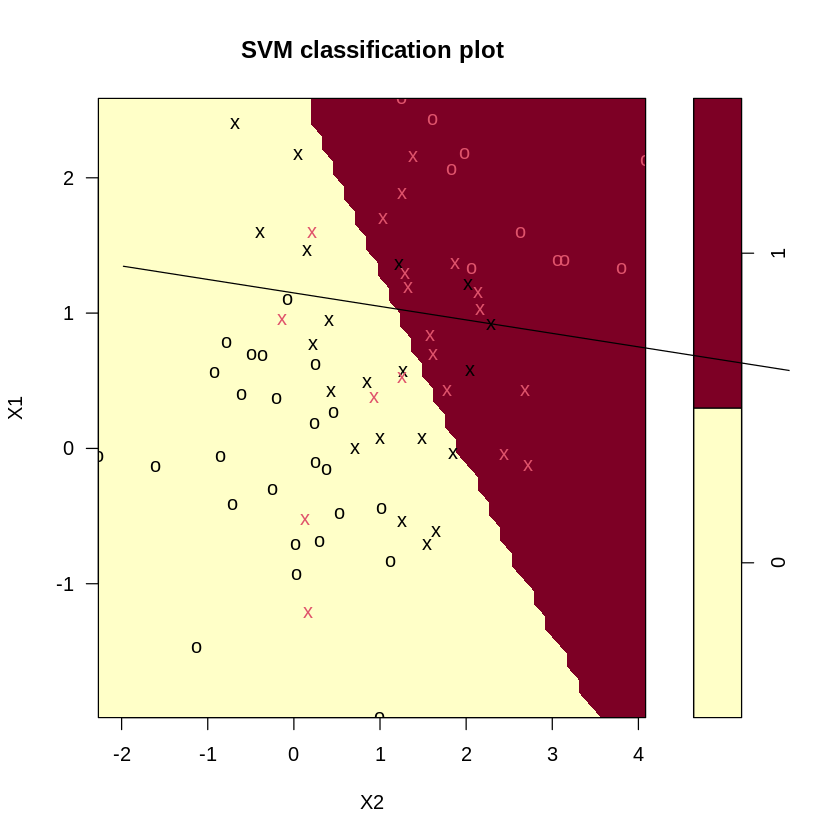

In [40]:
clasificador <- svm(
    Y ~ . ,data = train_100, 
    type = 'C-classification', 
    kernel = 'radial',
    gamma = gamma_optim_100,
    cost  = C_optim_100
)
plot(clasificador, train_100) # Imprimimos svm
abline(a=1.0625, b=-0.125)

#### Visualizaciósobre datos nuvos

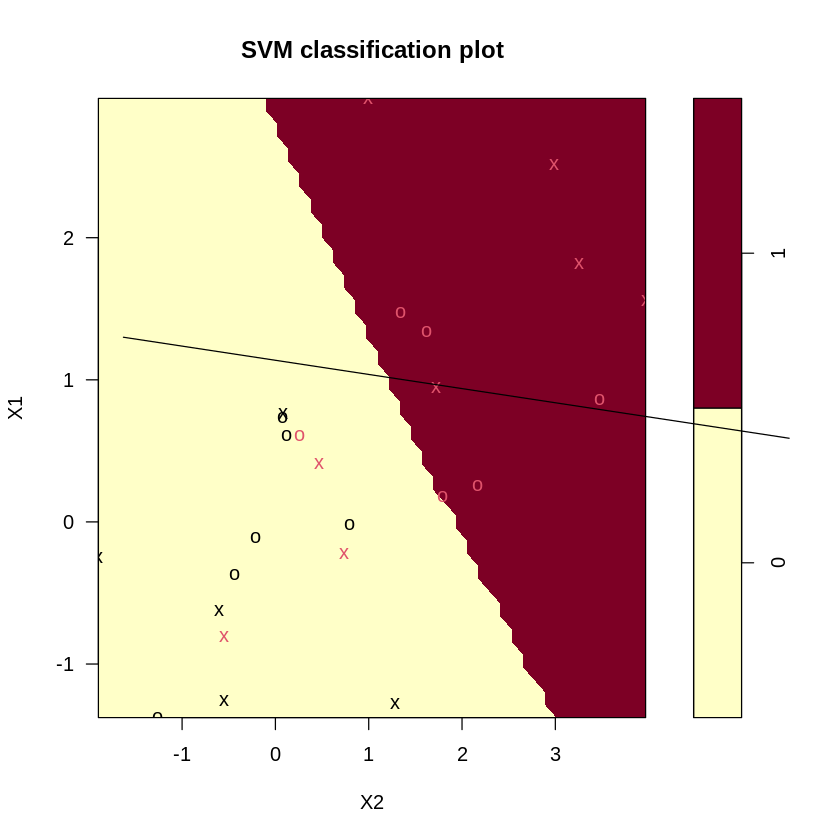

In [41]:
plot(clasificador, test_100) # Imprimimos svm
abline(a=1.0625, b=-0.125)

###500

#### Elección de modelo

En este caso, el modelo basado en SVM logra una precisión de $0.8$ sobre el conjunto de prueba, mientras que el clasificador Bayesiano óptimo obtiene $0.824$. Notamos que en esta ocacióón el clasificador Bayessiano óptimo obtiene una mejor precisión que el modelo basado en SVM.

Podemos notar que las fronteras de desición de ambos clasificadores se parecen menos que en el caso pasado, pero la frontera de desición del clasificador basado en SVM sigue teniendo una "dirección similar" a la de la recta inducida por el clasificador Bayessiano óptimo.

In [42]:
params <- svm_model(train_500, test_500, 10)
C_optim_500 <- params[1]
gamma_optim_500 <- params[2]

bayes_model(test_500)

[1] "(c, gamma, precision):"
[1] 10.00  0.00  0.84
[1] 10.00  0.00  0.85
[1] 10.00  0.01  0.84
[1] 10.00  0.10  0.84
[1] 10.00  1.00  0.85
[1] 10.00 10.00  0.82
[1] 100.00   0.00   0.84
[1] 100.00   0.00   0.84
[1] 100.00   0.01   0.84
[1] 100.00   0.10   0.84
[1] 100.00   1.00   0.85
[1] 100.00  10.00   0.77
[1] 1000.00    0.00    0.84
[1] 1000.00    0.00    0.84
[1] 1000.00    0.01    0.84
[1] 1000.00    0.10    0.85
[1] 1000.00    1.00    0.83
[1] 1000.00   10.00    0.76
[1] "(c*, gamma*):"
[1] 10  1
[1] "Precision del modelo:" "0.8"                  
[1] "Bayes"
[1] "Precision del modelo:"
[1] 0.824


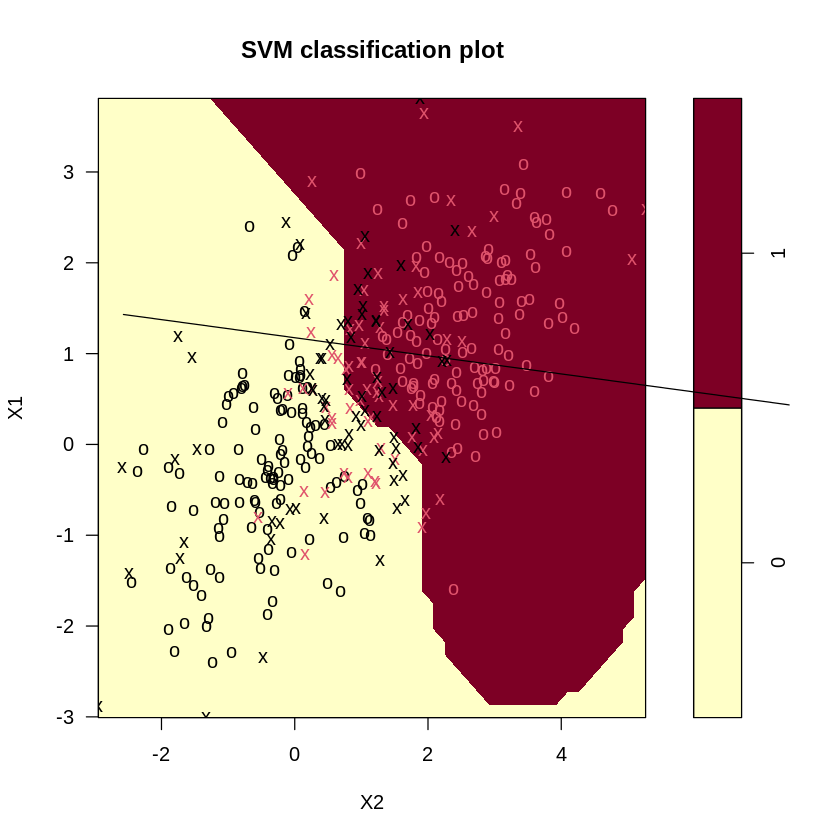

In [43]:
clasificador <- svm(
    Y ~ . ,data = train_500, 
    type = 'C-classification', 
    kernel = 'radial',
    gamma = gamma_optim_500,
    cost  = C_optim_500
)
plot(clasificador, train_500) # Imprimimos svm
abline(a=1.0625, b=-0.125)

#### Visualizaciósobre datos nuvos

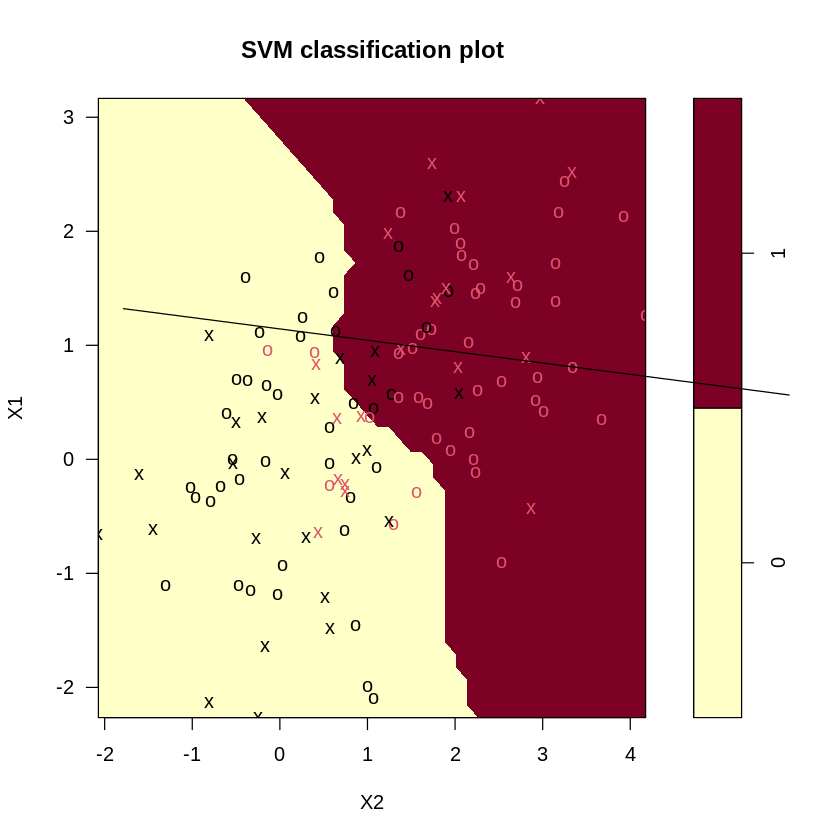

In [44]:
plot(clasificador, test_500) # Imprimimos svm
abline(a=1.0625, b=-0.125)

### Observaciones

Podemos notar en los recultados que el parámetro de costo $C$ no tiene mucha influencia en los resultados, pues podemos notar que la precisión obtenida con un $\gamma$ fijo no cambia mucho a pesar de cammbiar $C$.

En general, podemos observar resultados parecidos al clasificador Bayesiano óptimo. Cabe destacar que SVM tiene buenos resultados en los conjuntos pequeños, pero en el conjunto más grande es el clasificador Bayesiano óptimo el que obtiene una mejor precisión.

# Conclusiones

En general, los clasificadores tienen resultados buenos, teniendo en cuenta que los datos son dificiles de separar. Cabe señalar que se puede refianar más el espacio de búsqueda para cada clasificador, pero debido a los resultados obtenidos se decidió no refinar más.

Al comparar el Clasificador Bayesiano óptimo con los clasificadores obtenidos basados en árboles y SVM, podemos observar que los clasificadores logran una precision parecida en los conjuntos pequeños, pero conforme el tamaño de conjunto crece comenzamos a notar que el clasificador Bayesiano óptimo logra una mejor precisión.